In [1]:
# 파일이름 : data_integration.ipynb
# 코드설명 : 예측 대상별 데이터 통합 및 모델 학습 데이터 세트 생성
# 입/출력 : LAB, MES CMB, MES FMB 데이터 세트 / 물성별 데이터 세트 (17개)
# 유의 사항 : 무한대 값 제외
# 최종수정 : 2023년 11월 27일
# 제 작 자 : 홍민성 (mshong@micube.co.kr), 맹영준 (myj6223@micube.co.kr)
# Copyright : MICUBE Solution, Inc.

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font_list = [font.name for font in fm.fontManager.ttflist]
#print(font_list)

# 한글 폰트 설정
plt.rcParams["font.family"] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False # 유니코드 마이너스 사용 설정 (깨지는 문제 방지)

sns.set(font="NanumGothic", # 일반적으로 설치되어 있는 폰트로 변경
        rc={"axes.unicode_minus": False, "figure.figsize": (20, 8)}, # figure size와 unicode_min
        style='darkgrid',
        font_scale=0.8) # 폰트 크기 설정 추가

import pandas as pd
import numpy as np
import matplotlib
import warnings
%matplotlib inline
warnings.filterwarnings(action='ignore')
pd.set_option("display.max_columns", 500)
pd.set_option('display.max_rows', 50)
from tqdm.auto import tqdm

import os
import koreanize_matplotlib
import pingouin as pg

## 1. 기본물성 데이터 통합

In [2]:
in_file_path = './tmp_dataset/'
out_file_path = './final_dataset/'

lab_yCols = ['HS','SG','TS','EB']
mes_regr_yCols = ['HS','SG','TS','EB']

### 1) 최종 데이터셋의 형태(변수명) 정의

In [3]:
fin_cols = ['ID', 'TYPE', 'INSP_TIME', 'INSP_TEMP', 'RPM1', 'RPM2', 'RPM3', 'RPM4', 'RPM5', 'RPM6', 'RPM7', 'RPM8', 'RPM9', 'RPM10', 'RPM11', 'RPM12', 'RPM13', 'RPM14', 'RPM15', 'RPM16', 'RPM17', 'RPM18', 'RPM19', 'RPM20', 'RPM21', 'RPM22', 'RPM23', 'TEMP1', 'TEMP2', 'TEMP3', 'TEMP4', 'TEMP5', 'TEMP6', 'TEMP7', 'TEMP8', 'TEMP9', 'TEMP10', 'TEMP11', 'TEMP12', 'TEMP13', 'TEMP14', 'TEMP15', 'TEMP16', 'TEMP17', 'TEMP18', 'TEMP19', 'TEMP20', 'TEMP21', 'TEMP22', 'TEMP23', 'TIME1', 'TIME2', 'TIME3', 'TIME4', 'TIME5', 'TIME6', 'TIME7', 'TIME8', 'TIME9', 'TIME10', 'TIME11', 'TIME12', 'TIME13', 'TIME14', 'TIME15', 'TIME16', 'TIME17', 'TIME18', 'TIME19', 'TIME20', 'TIME21', 'TIME22', 'TIME23', 'JUK1', 'JUK2', 'JUK3', 'JUK4', 'JUK5', 'JUK6', 'JUK7', 'JUK8', 'JUK9', 'JUK10', 'JUK11', 'JUK12', 'JUK13', 'JUK14', 'JUK15', 'JUK16', 'JUK17', 'JUK18', 'JUK19', 'JUK20', 'JUK21', 'JUK22', 'JUK23', 'JRCODE1', 'JRCODE2', 'JRCODE3', 'JRCODE4', 'JRCODE5', 'JRCODE6', 'JRCODE7', 'JRCODE8', 'JRCODE9', 'JRCODE10', 'JRCODE11', 'JRCODE12', 'JRCODE13', 'JRCODE14', 'JRCODE15', 'JRCODE16', 'JRCODE17', 'JRCODE18', 'JRCODE19', 'JRCODE20', 'JRCODE21', 'JRCODE22', 'JRCODE23', 'JRCODE24', 'JRCODE25', 'PHR1', 'PHR2', 'PHR3', 'PHR4', 'PHR5', 'PHR6', 'PHR7', 'PHR8', 'PHR9', 'PHR10', 'PHR11', 'PHR12', 'PHR13', 'PHR14', 'PHR15', 'PHR16', 'PHR17', 'PHR18', 'PHR19', 'PHR20', 'PHR21', 'PHR22', 'PHR23', 'PHR24', 'PHR25', 'PUTGB1', 'PUTGB2', 'PUTGB3', 'PUTGB4', 'PUTGB5', 'PUTGB6', 'PUTGB7', 'PUTGB8', 'PUTGB9', 'PUTGB10', 'PUTGB11', 'PUTGB12', 'PUTGB13', 'PUTGB14', 'PUTGB15', 'PUTGB16', 'PUTGB17', 'PUTGB18', 'PUTGB19', 'PUTGB20', 'PUTGB21', 'PUTGB22', 'PUTGB23', 'PUTGB24', 'PUTGB25', 'REAL_VAL']

### 2) 물성값 예측(regression) 모델의 통합 데이터 세트 재구축

In [4]:
show_df = pd.DataFrame(columns=['TARGET','LAB#','CMB#','FMB#','TOTAL#'])

for i in np.arange(0,len(mes_regr_yCols)):
    lab_yCol = lab_yCols[i]
    mes_yCol = mes_regr_yCols[i]

    # 데이터별 컬럼명 단일화를 위한 dictionary 정의
    lab_rename_dic = {'lab_pk': 'ID', f'{lab_yCol}': 'REAL_VAL',
                           '1_JRCODE': 'JRCODE1', '2_JRCODE': 'JRCODE2', '3_JRCODE': 'JRCODE3', '4_JRCODE': 'JRCODE4', '5_JRCODE': 'JRCODE5', '6_JRCODE': 'JRCODE6', '7_JRCODE': 'JRCODE7', '8_JRCODE': 'JRCODE8', '9_JRCODE': 'JRCODE9', '10_JRCODE': 'JRCODE10', '11_JRCODE': 'JRCODE11', '12_JRCODE': 'JRCODE12', '13_JRCODE': 'JRCODE13', '14_JRCODE': 'JRCODE14', '15_JRCODE': 'JRCODE15', '16_JRCODE': 'JRCODE16', '17_JRCODE': 'JRCODE17', '18_JRCODE': 'JRCODE18', '19_JRCODE': 'JRCODE19', '20_JRCODE': 'JRCODE20',
                            '1_PHR': 'PHR1', '2_PHR': 'PHR2', '3_PHR': 'PHR3', '4_PHR': 'PHR4', '5_PHR': 'PHR5', '6_PHR': 'PHR6', '7_PHR': 'PHR7', '8_PHR': 'PHR8', '9_PHR': 'PHR9', '10_PHR': 'PHR10', '11_PHR': 'PHR11', '12_PHR': 'PHR12', '13_PHR': 'PHR13', '14_PHR': 'PHR14', '15_PHR': 'PHR15', '16_PHR': 'PHR16', '17_PHR': 'PHR17', '18_PHR': 'PHR18', '19_PHR': 'PHR19', '20_PHR': 'PHR20',
                           }
    mes_cmb_rename_dic = {'LOTNO': 'ID', f'{mes_yCol}': 'REAL_VAL', f'{mes_yCol}_TIME': 'INSP_TIME', f'{mes_yCol}_TEMP': 'INSP_TEMP', 
                            '1_JRCODE': 'JRCODE1', '2_JRCODE': 'JRCODE2', '3_JRCODE': 'JRCODE3', '4_JRCODE': 'JRCODE4', '5_JRCODE': 'JRCODE5', '6_JRCODE': 'JRCODE6', '7_JRCODE': 'JRCODE7', '8_JRCODE': 'JRCODE8', '9_JRCODE': 'JRCODE9', '10_JRCODE': 'JRCODE10', '11_JRCODE': 'JRCODE11', '12_JRCODE': 'JRCODE12', '13_JRCODE': 'JRCODE13', '14_JRCODE': 'JRCODE14', '15_JRCODE': 'JRCODE15', '16_JRCODE': 'JRCODE16', '17_JRCODE': 'JRCODE17', '18_JRCODE': 'JRCODE18', '19_JRCODE': 'JRCODE19', '20_JRCODE': 'JRCODE20', '21_JRCODE': 'JRCODE21',
                            '1_PHR': 'PHR1', '2_PHR': 'PHR2', '3_PHR': 'PHR3', '4_PHR': 'PHR4', '5_PHR': 'PHR5', '6_PHR': 'PHR6', '7_PHR': 'PHR7', '8_PHR': 'PHR8', '9_PHR': 'PHR9', '10_PHR': 'PHR10', '11_PHR': 'PHR11', '12_PHR': 'PHR12', '13_PHR': 'PHR13', '14_PHR': 'PHR14', '15_PHR': 'PHR15', '16_PHR': 'PHR16', '17_PHR': 'PHR17', '18_PHR': 'PHR18', '19_PHR': 'PHR19', '20_PHR': 'PHR20', '21_PHR': 'PHR21',
                            '1_PUTGB': 'PUTGB1', '2_PUTGB': 'PUTGB2', '3_PUTGB': 'PUTGB3', '4_PUTGB': 'PUTGB4', '5_PUTGB': 'PUTGB5', '6_PUTGB': 'PUTGB6', '7_PUTGB': 'PUTGB7', '8_PUTGB': 'PUTGB8', '9_PUTGB': 'PUTGB9', '10_PUTGB': 'PUTGB10', '11_PUTGB': 'PUTGB11', '12_PUTGB': 'PUTGB12', '13_PUTGB': 'PUTGB13', '14_PUTGB': 'PUTGB14', '15_PUTGB': 'PUTGB15', '16_PUTGB': 'PUTGB16', '17_PUTGB': 'PUTGB17', '18_PUTGB': 'PUTGB18', '19_PUTGB': 'PUTGB19', '20_PUTGB': 'PUTGB20', '21_PUTGB': 'PUTGB21'
                            }
    mes_fmb_rename_dic = {'LOTNO': 'ID', f'{mes_yCol}': 'REAL_VAL', f'{mes_yCol}_TEMP': 'INSP_TIME', f'{mes_yCol}_TEMP': 'INSP_TEMP',
                            '1_JRCODE': 'JRCODE1', '2_JRCODE': 'JRCODE2', '3_JRCODE': 'JRCODE3', '4_JRCODE': 'JRCODE4', '5_JRCODE': 'JRCODE5', '6_JRCODE': 'JRCODE6', '7_JRCODE': 'JRCODE7', '8_JRCODE': 'JRCODE8', '9_JRCODE': 'JRCODE9', '10_JRCODE': 'JRCODE10', '11_JRCODE': 'JRCODE11', '12_JRCODE': 'JRCODE12', '13_JRCODE': 'JRCODE13', '14_JRCODE': 'JRCODE14', '15_JRCODE': 'JRCODE15', '16_JRCODE': 'JRCODE16', '17_JRCODE': 'JRCODE17', '18_JRCODE': 'JRCODE18', '19_JRCODE': 'JRCODE19', '20_JRCODE': 'JRCODE20', '21_JRCODE': 'JRCODE21', '22_JRCODE': 'JRCODE22', '23_JRCODE': 'JRCODE23', '24_JRCODE': 'JRCODE24', '25_JRCODE': 'JRCODE25',
                            '1_PHR': 'PHR1', '2_PHR': 'PHR2', '3_PHR': 'PHR3', '4_PHR': 'PHR4', '5_PHR': 'PHR5', '6_PHR': 'PHR6', '7_PHR': 'PHR7', '8_PHR': 'PHR8', '9_PHR': 'PHR9', '10_PHR': 'PHR10', '11_PHR': 'PHR11', '12_PHR': 'PHR12', '13_PHR': 'PHR13', '14_PHR': 'PHR14', '15_PHR': 'PHR15', '16_PHR': 'PHR16', '17_PHR': 'PHR17', '18_PHR': 'PHR18', '19_PHR': 'PHR19', '20_PHR': 'PHR20', '21_PHR': 'PHR21', '22_PHR': 'PHR22', '23_PHR': 'PHR23', '24_PHR': 'PHR24', '25_PHR': 'PHR25',
                            '1_PUTGB': 'PUTGB1', '2_PUTGB': 'PUTGB2', '3_PUTGB': 'PUTGB3', '4_PUTGB': 'PUTGB4', '5_PUTGB': 'PUTGB5', '6_PUTGB': 'PUTGB6', '7_PUTGB': 'PUTGB7', '8_PUTGB': 'PUTGB8', '9_PUTGB': 'PUTGB9', '10_PUTGB': 'PUTGB10', '11_PUTGB': 'PUTGB11', '12_PUTGB': 'PUTGB12', '13_PUTGB': 'PUTGB13', '14_PUTGB': 'PUTGB14', '15_PUTGB': 'PUTGB15', '16_PUTGB': 'PUTGB16', '17_PUTGB': 'PUTGB17', '18_PUTGB': 'PUTGB18', '19_PUTGB': 'PUTGB19', '20_PUTGB': 'PUTGB20', '21_PUTGB': 'PUTGB21', '22_PUTGB': 'PUTGB22', '23_PUTGB': 'PUTGB23', '24_PUTGB': 'PUTGB24', '25_PUTGB': 'PUTGB25',
                            }

    # 데이터별 파일 로드
    lab_regr_df = pd.read_csv(in_file_path+f'lab_regr_data_{lab_yCol}_fin_noZero.csv')
    mes_cmb_df = pd.read_csv(in_file_path+f'mes_regr_cmb_data_{mes_yCol}_fin_noZero.csv')
    mes_fmb_df = pd.read_csv(in_file_path+f'mes_regr_fmb_data_{mes_yCol}_fin_noZero_24040418.csv')

    # 데이터별 컬럼명 단일화
    lab_regr_df.rename(columns=lab_rename_dic,inplace=True)
    mes_cmb_df.rename(columns=mes_cmb_rename_dic,inplace=True)
    mes_fmb_df.rename(columns=mes_fmb_rename_dic,inplace=True)

    # 데이터 종류 변수 추가
    lab_regr_df['TYPE'] = 'LAB'
    mes_cmb_df['TYPE'] = 'mCMB'
    mes_fmb_df['TYPE'] = 'mFMB'

    # 데이터별 누락된 컬럼을 nan값을 채워서 추가
    for fCol in fin_cols:
        if fCol not in lab_regr_df.columns:
            lab_regr_df[fCol] = np.nan
        if fCol not in mes_cmb_df.columns:
            mes_cmb_df[fCol] = np.nan
        if fCol not in mes_fmb_df.columns:
            mes_fmb_df[fCol] = np.nan

    # 필요 없는 컬럼 제거
    mes_fmb_df.drop(columns=['RUBBER'], inplace=True)

    # 컬럼 순서 동일화
    lab_regr_df = lab_regr_df[fin_cols]
    mes_cmb_df = mes_cmb_df[fin_cols]
    mes_fmb_df = mes_fmb_df[fin_cols]

    # 데이터 통합
    combined_base_df = pd.concat([lab_regr_df, mes_cmb_df, mes_fmb_df])

    # 결과 출력
    display(f'LAB: {lab_regr_df.shape}, CMB: {mes_cmb_df.shape}, FMB: {mes_fmb_df.shape}, TOTAL: {combined_base_df.shape}')

    # 통합 데이터 저장
    combined_base_df.to_csv(out_file_path+f'combined_data_{mes_yCol}_fin.csv', index=False)
    # 무한대 라벨 값 Nan으로 대체
    combined_base_df['REAL_VAL'].replace([np.inf, -np.inf], np.nan, inplace=True)
    # Nan 라벨 값 제거
    combined_base_df.dropna(subset=['REAL_VAL'], how="all", inplace=True)

    # 통합 결과 저장
    show_df.loc[len(show_df)] = [mes_yCol, len(lab_regr_df), len(mes_cmb_df), len(mes_fmb_df), len(combined_base_df)]
    
show_df

'LAB: (4278, 172), CMB: (13506, 172), FMB: (31095, 172), TOTAL: (48879, 172)'

'LAB: (4129, 172), CMB: (56637, 172), FMB: (28053, 172), TOTAL: (88819, 172)'

'LAB: (4104, 172), CMB: (12915, 172), FMB: (29516, 172), TOTAL: (46535, 172)'

'LAB: (4241, 172), CMB: (13189, 172), FMB: (29716, 172), TOTAL: (47146, 172)'

,TARGET,LAB#,CMB#,FMB#,TOTAL#
0,HS,4278,13506,31095,48879
1,SG,4129,56637,28053,88819
2,TS,4104,12915,29516,46535
3,EB,4241,13189,29716,47146


## 2. 가류도/점성 데이터 통합

In [5]:
in_file_path = './tmp_dataset/'
out_file_path = './final_dataset/'

lab_yCols = ['MNY_MIN','MNY_T5','MNY_T35','REHO_MIN','REHO_MAX','REHO_TS2','REHO_TC90']
mes_regr_yCols = ['MNY_MIN','MNY_T5','MNY_T35','REHO_MIN','REHO_MAX','REHO_TS2','REHO_TC90']

### 1) 최종 데이터셋의 형태(변수명) 정의

In [6]:
fin_cols = ['ID', 'TYPE', 'INSP_TIME', 'INSP_TEMP', 'RPM1', 'RPM2', 'RPM3', 'RPM4', 'RPM5', 'RPM6', 'RPM7', 'RPM8', 'RPM9', 'RPM10', 'RPM11', 'RPM12', 'RPM13', 'RPM14', 'RPM15', 'RPM16', 'RPM17', 'RPM18', 'RPM19', 'RPM20', 'RPM21', 'RPM22', 'RPM23', 'TEMP1', 'TEMP2', 'TEMP3', 'TEMP4', 'TEMP5', 'TEMP6', 'TEMP7', 'TEMP8', 'TEMP9', 'TEMP10', 'TEMP11', 'TEMP12', 'TEMP13', 'TEMP14', 'TEMP15', 'TEMP16', 'TEMP17', 'TEMP18', 'TEMP19', 'TEMP20', 'TEMP21', 'TEMP22', 'TEMP23', 'TIME1', 'TIME2', 'TIME3', 'TIME4', 'TIME5', 'TIME6', 'TIME7', 'TIME8', 'TIME9', 'TIME10', 'TIME11', 'TIME12', 'TIME13', 'TIME14', 'TIME15', 'TIME16', 'TIME17', 'TIME18', 'TIME19', 'TIME20', 'TIME21', 'TIME22', 'TIME23', 'JUK1', 'JUK2', 'JUK3', 'JUK4', 'JUK5', 'JUK6', 'JUK7', 'JUK8', 'JUK9', 'JUK10', 'JUK11', 'JUK12', 'JUK13', 'JUK14', 'JUK15', 'JUK16', 'JUK17', 'JUK18', 'JUK19', 'JUK20', 'JUK21', 'JUK22', 'JUK23', 'JRCODE1', 'JRCODE2', 'JRCODE3', 'JRCODE4', 'JRCODE5', 'JRCODE6', 'JRCODE7', 'JRCODE8', 'JRCODE9', 'JRCODE10', 'JRCODE11', 'JRCODE12', 'JRCODE13', 'JRCODE14', 'JRCODE15', 'JRCODE16', 'JRCODE17', 'JRCODE18', 'JRCODE19', 'JRCODE20', 'JRCODE21', 'JRCODE22', 'JRCODE23', 'JRCODE24', 'JRCODE25', 'PHR1', 'PHR2', 'PHR3', 'PHR4', 'PHR5', 'PHR6', 'PHR7', 'PHR8', 'PHR9', 'PHR10', 'PHR11', 'PHR12', 'PHR13', 'PHR14', 'PHR15', 'PHR16', 'PHR17', 'PHR18', 'PHR19', 'PHR20', 'PHR21', 'PHR22', 'PHR23', 'PHR24', 'PHR25', 'PUTGB1', 'PUTGB2', 'PUTGB3', 'PUTGB4', 'PUTGB5', 'PUTGB6', 'PUTGB7', 'PUTGB8', 'PUTGB9', 'PUTGB10', 'PUTGB11', 'PUTGB12', 'PUTGB13', 'PUTGB14', 'PUTGB15', 'PUTGB16', 'PUTGB17', 'PUTGB18', 'PUTGB19', 'PUTGB20', 'PUTGB21', 'PUTGB22', 'PUTGB23', 'PUTGB24', 'PUTGB25', 'REAL_VAL']

### 2) 물성값 예측(regression) 모델의 통합 데이터 세트 재구축

In [10]:
mes_cmb_df

,ID,RUBBER,RPM1,RPM2,RPM3,RPM4,RPM5,RPM6,RPM7,RPM8,RPM9,RPM10,RPM11,RPM12,RPM13,RPM14,RPM15,RPM16,RPM17,RPM18,RPM19,RPM20,TEMP1,TEMP2,TEMP3,TEMP4,TEMP5,TEMP6,TEMP7,TEMP8,TEMP9,TEMP10,TEMP11,TEMP12,TEMP13,TEMP14,TEMP15,TEMP16,TEMP17,TEMP18,TEMP19,TEMP20,TIME1,TIME2,TIME3,TIME4,TIME5,TIME6,TIME7,TIME8,TIME9,TIME10,TIME11,TIME12,TIME13,TIME14,TIME15,TIME16,TIME17,TIME18,TIME19,TIME20,JUK1,JUK2,JUK3,JUK4,JUK5,JUK6,JUK7,JUK8,JUK9,JUK10,JUK11,JUK12,JUK13,JUK14,JUK15,JUK16,JUK17,JUK18,JUK19,JUK20,JRCODE1,JRCODE2,JRCODE3,JRCODE4,JRCODE5,JRCODE6,JRCODE7,JRCODE8,JRCODE9,JRCODE10,JRCODE11,JRCODE12,JRCODE13,JRCODE14,JRCODE15,JRCODE16,JRCODE17,JRCODE18,JRCODE19,JRCODE20,JRCODE21,PHR1,PHR2,PHR3,PHR4,PHR5,PHR6,PHR7,PHR8,PHR9,PHR10,PHR11,PHR12,PHR13,PHR14,PHR15,PHR16,PHR17,PHR18,PHR19,PHR20,PHR21,PUTGB1,PUTGB2,PUTGB3,PUTGB4,PUTGB5,PUTGB6,PUTGB7,PUTGB8,PUTGB9,PUTGB10,PUTGB11,PUTGB12,PUTGB13,PUTGB14,PUTGB15,PUTGB16,PUTGB17,PUTGB18,PUTGB19,PUTGB20,PUTGB21,MNY_TIME,MNY_TEMP,REAL_VAL,TYPE
0,G0116K170014004,1502-B2.01-C1,1197.0,1204.0,1203.0,1204.0,1202.0,1207.0,1206.0,1205.0,1204.0,1203.0,1203.0,1202.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,128.4,83.4,70.7,67.0,100.8,112.7,150.1,139.3,142.1,139.9,164.7,151.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,9.4,34.4,33.6,28.9,8.9,26.7,21.5,19.5,7.1,100.6,16.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49.0,12.0,81.0,43.0,64.0,28.0,43.0,106.0,67.0,44.0,167.0,56.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,EE017A,EE011A,CB011B,CB006A,CB003A,NN031A,OP004A,FF001D,OP004A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.5,75.0,1.2,0.8,5.00,98.0,67.0,10.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,2.0,3.0,4.0,2.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,125.0,22.0,mCMB
1,G0116K170014006,1502-B2.01-C1,1200.0,1203.0,1204.0,1204.0,1204.0,1206.0,1205.0,1203.0,1203.0,1204.0,1206.0,1203.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,132.5,86.5,71.1,67.3,101.3,113.3,150.5,140.9,139.8,141.9,164.6,151.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.8,9.4,34.4,33.8,29.7,9.1,27.1,21.0,19.6,6.9,95.2,16.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41.0,30.0,86.0,60.0,78.0,3.0,58.0,95.0,55.0,42.0,206.0,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,EE017A,EE011A,CB011B,CB006A,CB003A,NN031A,OP004A,FF001D,OP004A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.5,75.0,1.2,0.8,5.00,98.0,67.0,10.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,2.0,3.0,4.0,2.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,125.0,24.0,mCMB
2,G0116K170014018,1502-B2.01-C1,1201.0,1204.0,1204.0,1202.0,1203.0,1206.0,1204.0,1203.0,1203.0,1205.0,1203.0,1203.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,130.2,85.7,73.5,67.7,100.8,111.6,149.9,143.7,141.7,135.1,164.5,150.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.7,9.4,34.4,33.8,30.4,8.9,27.7,21.6,19.6,26.4,89.4,16.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,9.0,58.0,43.0,51.0,15.0,49.0,135.0,65.0,159.0,201.0,46.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,EE017A,EE011A,CB011B,CB006A,CB003A,NN031A,OP004A,FF001D,OP004A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.5,75.0,1.2,0.8,5.00,98.0,67.0,10.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,2.0,3.0,4.0,2.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,125.0,23.0,mCMB
3,G0116K170014013,1502-B2.01-C1,1200.0,1206.0,1204.0,1206.0,1201.0,1207.0,1206.0,1203.0,1203.0,1203.0,1205.0,1202.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,133.4,88.9,73.8,68.5,100.8,111.8,150.1,142.4,143.8,140.2,164.6,151.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.6,9.4,34.4,33.8,28.9,8.9,27.0,21.4,19.6,6.9,103.9,16.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,16.0,109.0,32.0,83.0,21.0,88.0,94.0,53.0,40.0,184.0,66.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,EE017A,EE011A,CB011B,CB006A,CB003A,NN031A,OP004A,FF001D,OP004A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.5,75.0,1.2,0.8,5.00,98.0,67.0,10.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,2.0,3.0,4.0,2.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,125.0,24.0,mCMB
4,G0116L020006001,1504-B3.00-C1,1203.0,1204.0,1203.0,1203.0,1206

In [25]:
show_df = pd.DataFrame(columns=['TARGET','LAB#','CMB#','FMB#','TOTAL#'])

for i in np.arange(0,len(mes_regr_yCols)):
    # Lab 데이터 처리
    try:
        lab_yCol = lab_yCols[i]
        # 데이터별 컬럼명 단일화를 위한 dictionary 정의
        lab_rename_dic = {'lab_pk': 'ID', f'{lab_yCol}': 'REAL_VAL',
                          '1_JRCODE': 'JRCODE1', '2_JRCODE': 'JRCODE2', '3_JRCODE': 'JRCODE3', '4_JRCODE': 'JRCODE4', '5_JRCODE': 'JRCODE5', '6_JRCODE': 'JRCODE6', '7_JRCODE': 'JRCODE7', '8_JRCODE': 'JRCODE8', '9_JRCODE': 'JRCODE9', '10_JRCODE': 'JRCODE10', '11_JRCODE': 'JRCODE11', '12_JRCODE': 'JRCODE12', '13_JRCODE': 'JRCODE13', '14_JRCODE': 'JRCODE14', '15_JRCODE': 'JRCODE15', '16_JRCODE': 'JRCODE16', '17_JRCODE': 'JRCODE17', '18_JRCODE': 'JRCODE18', '19_JRCODE': 'JRCODE19', '20_JRCODE': 'JRCODE20',
                          '1_PHR': 'PHR1', '2_PHR': 'PHR2', '3_PHR': 'PHR3', '4_PHR': 'PHR4', '5_PHR': 'PHR5', '6_PHR': 'PHR6', '7_PHR': 'PHR7', '8_PHR': 'PHR8', '9_PHR': 'PHR9', '10_PHR': 'PHR10', '11_PHR': 'PHR11', '12_PHR': 'PHR12', '13_PHR': 'PHR13', '14_PHR': 'PHR14', '15_PHR': 'PHR15', '16_PHR': 'PHR16', '17_PHR': 'PHR17', '18_PHR': 'PHR18', '19_PHR': 'PHR19', '20_PHR': 'PHR20'
                          }
    except:
        lab_yCol = 'NO'
        lab_rename_dic = np.nan
    
    mes_yCol = mes_regr_yCols[i]
    ##### 새로 추가 ####
    prefix = mes_yCol.split('_')[0]

    print('<<' + mes_yCol + '>>')

    mes_cmb_rename_dic = {'LOTNO': 'ID', f'{mes_yCol}': 'REAL_VAL', f'{prefix}_TIME': 'INSP_TIME', f'{prefix}_TEMP': 'INSP_TEMP', 
                            '1_JRCODE': 'JRCODE1', '2_JRCODE': 'JRCODE2', '3_JRCODE': 'JRCODE3', '4_JRCODE': 'JRCODE4', '5_JRCODE': 'JRCODE5', '6_JRCODE': 'JRCODE6', '7_JRCODE': 'JRCODE7', '8_JRCODE': 'JRCODE8', '9_JRCODE': 'JRCODE9', '10_JRCODE': 'JRCODE10', '11_JRCODE': 'JRCODE11', '12_JRCODE': 'JRCODE12', '13_JRCODE': 'JRCODE13', '14_JRCODE': 'JRCODE14', '15_JRCODE': 'JRCODE15', '16_JRCODE': 'JRCODE16', '17_JRCODE': 'JRCODE17', '18_JRCODE': 'JRCODE18', '19_JRCODE': 'JRCODE19', '20_JRCODE': 'JRCODE20', '21_JRCODE': 'JRCODE21',
                            '1_PHR': 'PHR1', '2_PHR': 'PHR2', '3_PHR': 'PHR3', '4_PHR': 'PHR4', '5_PHR': 'PHR5', '6_PHR': 'PHR6', '7_PHR': 'PHR7', '8_PHR': 'PHR8', '9_PHR': 'PHR9', '10_PHR': 'PHR10', '11_PHR': 'PHR11', '12_PHR': 'PHR12', '13_PHR': 'PHR13', '14_PHR': 'PHR14', '15_PHR': 'PHR15', '16_PHR': 'PHR16', '17_PHR': 'PHR17', '18_PHR': 'PHR18', '19_PHR': 'PHR19', '20_PHR': 'PHR20', '21_PHR': 'PHR21',
                            '1_PUTGB': 'PUTGB1', '2_PUTGB': 'PUTGB2', '3_PUTGB': 'PUTGB3', '4_PUTGB': 'PUTGB4', '5_PUTGB': 'PUTGB5', '6_PUTGB': 'PUTGB6', '7_PUTGB': 'PUTGB7', '8_PUTGB': 'PUTGB8', '9_PUTGB': 'PUTGB9', '10_PUTGB': 'PUTGB10', '11_PUTGB': 'PUTGB11', '12_PUTGB': 'PUTGB12', '13_PUTGB': 'PUTGB13', '14_PUTGB': 'PUTGB14', '15_PUTGB': 'PUTGB15', '16_PUTGB': 'PUTGB16', '17_PUTGB': 'PUTGB17', '18_PUTGB': 'PUTGB18', '19_PUTGB': 'PUTGB19', '20_PUTGB': 'PUTGB20', '21_PUTGB': 'PUTGB21'
                            }
    mes_fmb_rename_dic = {'LOTNO': 'ID', f'{mes_yCol}': 'REAL_VAL', f'{prefix}_TIME': 'INSP_TIME', f'{prefix}_TEMP': 'INSP_TEMP',
                            '1_JRCODE': 'JRCODE1', '2_JRCODE': 'JRCODE2', '3_JRCODE': 'JRCODE3', '4_JRCODE': 'JRCODE4', '5_JRCODE': 'JRCODE5', '6_JRCODE': 'JRCODE6', '7_JRCODE': 'JRCODE7', '8_JRCODE': 'JRCODE8', '9_JRCODE': 'JRCODE9', '10_JRCODE': 'JRCODE10', '11_JRCODE': 'JRCODE11', '12_JRCODE': 'JRCODE12', '13_JRCODE': 'JRCODE13', '14_JRCODE': 'JRCODE14', '15_JRCODE': 'JRCODE15', '16_JRCODE': 'JRCODE16', '17_JRCODE': 'JRCODE17', '18_JRCODE': 'JRCODE18', '19_JRCODE': 'JRCODE19', '20_JRCODE': 'JRCODE20', '21_JRCODE': 'JRCODE21', '22_JRCODE': 'JRCODE22', '23_JRCODE': 'JRCODE23', '24_JRCODE': 'JRCODE24', '25_JRCODE': 'JRCODE25',
                            '1_PHR': 'PHR1', '2_PHR': 'PHR2', '3_PHR': 'PHR3', '4_PHR': 'PHR4', '5_PHR': 'PHR5', '6_PHR': 'PHR6', '7_PHR': 'PHR7', '8_PHR': 'PHR8', '9_PHR': 'PHR9', '10_PHR': 'PHR10', '11_PHR': 'PHR11', '12_PHR': 'PHR12', '13_PHR': 'PHR13', '14_PHR': 'PHR14', '15_PHR': 'PHR15', '16_PHR': 'PHR16', '17_PHR': 'PHR17', '18_PHR': 'PHR18', '19_PHR': 'PHR19', '20_PHR': 'PHR20', '21_PHR': 'PHR21', '22_PHR': 'PHR22', '23_PHR': 'PHR23', '24_PHR': 'PHR24', '25_PHR': 'PHR25',
                            '1_PUTGB': 'PUTGB1', '2_PUTGB': 'PUTGB2', '3_PUTGB': 'PUTGB3', '4_PUTGB': 'PUTGB4', '5_PUTGB': 'PUTGB5', '6_PUTGB': 'PUTGB6', '7_PUTGB': 'PUTGB7', '8_PUTGB': 'PUTGB8', '9_PUTGB': 'PUTGB9', '10_PUTGB': 'PUTGB10', '11_PUTGB': 'PUTGB11', '12_PUTGB': 'PUTGB12', '13_PUTGB': 'PUTGB13', '14_PUTGB': 'PUTGB14', '15_PUTGB': 'PUTGB15', '16_PUTGB': 'PUTGB16', '17_PUTGB': 'PUTGB17', '18_PUTGB': 'PUTGB18', '19_PUTGB': 'PUTGB19', '20_PUTGB': 'PUTGB20', '21_PUTGB': 'PUTGB21', '22_PUTGB': 'PUTGB22', '23_PUTGB': 'PUTGB23', '24_PUTGB': 'PUTGB24', '25_PUTGB': 'PUTGB25',
                            }
    
    # 데이터별 파일 로드    
    if lab_yCol != 'NO': lab_regr_df = pd.read_csv(in_file_path+f'lab_regr_data_{lab_yCol}_fin_noZero.csv')
    mes_cmb_df = pd.read_csv(in_file_path+f'mes_regr_cmb_data_{mes_yCol}_fin_noZero.csv')
    mes_fmb_df = pd.read_csv(in_file_path+f'mes_regr_fmb_data_{mes_yCol}_fin_noZero_24040418.csv')

    # 데이터별 컬럼명 단일화
    if lab_yCol != 'NO': lab_regr_df.rename(columns=lab_rename_dic,inplace=True)
    mes_cmb_df.rename(columns=mes_cmb_rename_dic,inplace=True)
    mes_fmb_df.rename(columns=mes_fmb_rename_dic,inplace=True)

    # 데이터 종류 변수 추가
    if lab_yCol != 'NO': lab_regr_df['TYPE'] = 'LAB'
    mes_cmb_df['TYPE'] = 'mCMB'
    mes_fmb_df['TYPE'] = 'mFMB'

    # 데이터별 누락된 컬럼을 nan값을 채워서 추가
    for fCol in fin_cols:
        if (fCol not in lab_regr_df.columns) and (lab_yCol != 'NO'):
            lab_regr_df[fCol] = np.nan
        if fCol not in mes_cmb_df.columns:
            mes_cmb_df[fCol] = np.nan
        if fCol not in mes_fmb_df.columns:
            mes_fmb_df[fCol] = np.nan

    # 필요 없는 컬럼 제거
    mes_fmb_df.drop(columns=['RUBBER'], inplace=True)

    # 컬럼 순서 동일화
    if lab_yCol != 'NO': lab_regr_df = lab_regr_df[fin_cols]
    mes_cmb_df = mes_cmb_df[fin_cols]
    mes_fmb_df = mes_fmb_df[fin_cols]

    # 데이터 통합 및 결과 출력
    if lab_yCol != 'NO':
        combined_spec_df = pd.concat([lab_regr_df, mes_cmb_df, mes_fmb_df])
        if prefix == 'MNY':
            combined_spec_df.loc[combined_spec_df['INSP_TEMP'].isna(), 'INSP_TEMP'] = 125
            combined_spec_df.loc[combined_spec_df['INSP_TIME'].isna(), 'INSP_TIME'] = 5
        display(f'{mes_yCol} >> LAB: {lab_regr_df.shape}, CMB: {mes_cmb_df.shape}, FMB: {mes_fmb_df.shape}, TOTAL: {combined_spec_df.shape}')
    else:
        combined_spec_df = pd.concat([mes_cmb_df, mes_fmb_df])
        if prefix == 'MNY':
            combined_spec_df.loc[combined_spec_df['INSP_TEMP'].isna(), 'INSP_TEMP'] = 125
            combined_spec_df.loc[combined_spec_df['INSP_TIME'].isna(), 'INSP_TIME'] = 5
        display(f'{mes_yCol} >> LAB: No, CMB: {mes_cmb_df.shape}, FMB: {mes_fmb_df.shape}, TOTAL: {combined_spec_df.shape}')

    tmp_lab = combined_spec_df[combined_spec_df['TYPE']=='LAB']
    tmp_cmb = combined_spec_df[combined_spec_df['TYPE']=='mCMB']
    tmp_fmb = combined_spec_df[combined_spec_df['TYPE']=='mFMB']
    print(f'LAB {len(tmp_lab)}, TIME {len(tmp_lab[tmp_lab["INSP_TIME"].isna()])}, TEMP {len(tmp_lab[tmp_lab["INSP_TEMP"].isna()])}')
    print(f'CMB {len(tmp_cmb)}, TIME {len(tmp_cmb[tmp_cmb["INSP_TIME"].isna()])}, TEMP {len(tmp_cmb[tmp_cmb["INSP_TEMP"].isna()])}')
    print(f'FMB {len(tmp_fmb)}, TIME {len(tmp_fmb[tmp_fmb["INSP_TIME"].isna()])}, TEMP {len(tmp_fmb[tmp_fmb["INSP_TEMP"].isna()])}')
    print('='*80)
   
    # 통합 데이터 저장
    combined_spec_df.to_csv(out_file_path+f'combined_data_{mes_yCol}_fin.csv', index=False)
    # 무한대 라벨 값 Nan으로 대체
    combined_spec_df['REAL_VAL'].replace([np.inf, -np.inf], np.nan, inplace=True)
    # Nan 라벨 값 제거
    combined_spec_df.dropna(subset=['REAL_VAL'], how="all", inplace=True)

    # 통합 결과 저장
    if lab_yCol != 'NO':
        show_df.loc[len(show_df)] = [mes_yCol, len(lab_regr_df), len(mes_cmb_df), len(mes_fmb_df), len(combined_spec_df)]
    else:
        show_df.loc[len(show_df)] = [mes_yCol, 0, len(mes_cmb_df), len(mes_fmb_df), len(combined_spec_df)]        
    
show_df

<<MNY>>
LAB 3161, TIME 0, TEMP 0
CMB 74643, TIME 56778, TEMP 26346
FMB 60522, TIME 47763, TEMP 7


'MNY_MIN >> LAB: (3161, 172), CMB: (74643, 172), FMB: (60522, 172), TOTAL: (138326, 172)'

LAB 3161, TIME 0, TEMP 0
CMB 74643, TIME 0, TEMP 0
FMB 60522, TIME 0, TEMP 0
<<MNY>>
LAB 3892, TIME 0, TEMP 0
CMB 13181, TIME 6596, TEMP 7
FMB 55740, TIME 43636, TEMP 7


'MNY_T5 >> LAB: (3892, 172), CMB: (13181, 172), FMB: (55740, 172), TOTAL: (72813, 172)'

LAB 3892, TIME 0, TEMP 0
CMB 13181, TIME 0, TEMP 0
FMB 55740, TIME 0, TEMP 0
<<MNY>>
LAB 3284, TIME 0, TEMP 0
CMB 9769, TIME 4651, TEMP 6
FMB 44599, TIME 34668, TEMP 6


'MNY_T35 >> LAB: (3284, 172), CMB: (9769, 172), FMB: (44599, 172), TOTAL: (57652, 172)'

LAB 3284, TIME 0, TEMP 0
CMB 9769, TIME 0, TEMP 0
FMB 44599, TIME 0, TEMP 0
<<REHO>>
LAB 3823, TIME 0, TEMP 0
CMB 14826, TIME 6, TEMP 6
FMB 287734, TIME 29, TEMP 29


'REHO_MIN >> LAB: (3823, 172), CMB: (14826, 172), FMB: (287734, 172), TOTAL: (306383, 172)'

LAB 3823, TIME 0, TEMP 0
CMB 14826, TIME 6, TEMP 6
FMB 287734, TIME 29, TEMP 29
<<REHO>>
LAB 4305, TIME 0, TEMP 0
CMB 15131, TIME 6, TEMP 6
FMB 288701, TIME 29, TEMP 29


'REHO_MAX >> LAB: (4305, 172), CMB: (15131, 172), FMB: (288701, 172), TOTAL: (308137, 172)'

LAB 4305, TIME 0, TEMP 0
CMB 15131, TIME 6, TEMP 6
FMB 288701, TIME 29, TEMP 29
<<REHO>>
LAB 4137, TIME 0, TEMP 0
CMB 14906, TIME 5, TEMP 5
FMB 254879, TIME 29, TEMP 29


'REHO_TS2 >> LAB: (4137, 172), CMB: (14906, 172), FMB: (254879, 172), TOTAL: (273922, 172)'

LAB 4137, TIME 0, TEMP 0
CMB 14906, TIME 5, TEMP 5
FMB 254879, TIME 29, TEMP 29
<<REHO>>
LAB 3723, TIME 0, TEMP 0
CMB 14733, TIME 6, TEMP 6
FMB 262851, TIME 29, TEMP 29


'REHO_TC90 >> LAB: (3723, 172), CMB: (14733, 172), FMB: (262851, 172), TOTAL: (281307, 172)'

LAB 3723, TIME 0, TEMP 0
CMB 14733, TIME 6, TEMP 6
FMB 262851, TIME 29, TEMP 29


,TARGET,LAB#,CMB#,FMB#,TOTAL#
0,MNY_MIN,3161,74643,60522,138326
1,MNY_T5,3892,13181,55740,72813
2,MNY_T35,3284,9769,44599,57652
3,REHO_MIN,3823,14826,287734,306383
4,REHO_MAX,4305,15131,288701,308137
5,REHO_TS2,4137,14906,254879,273922
6,REHO_TC90,3723,14733,262851,281307


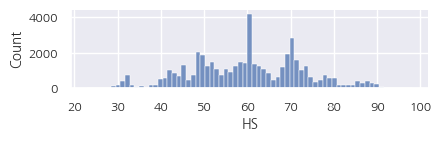

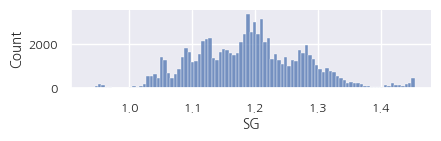

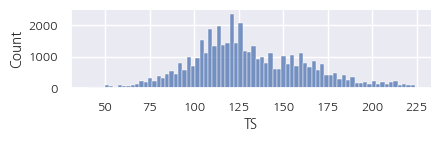

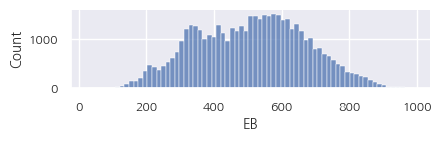

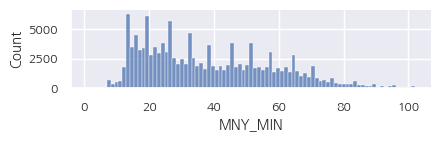

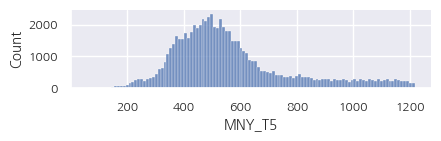

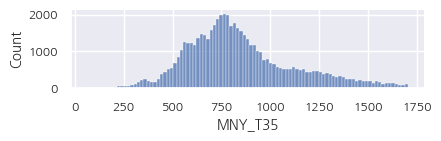

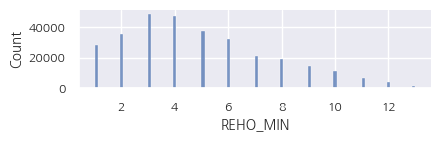

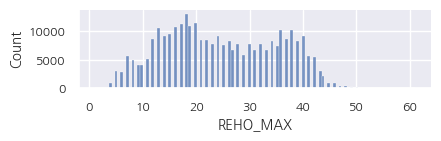

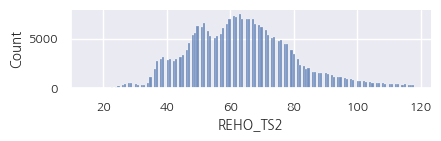

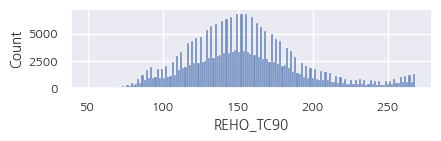

In [39]:
trg_cols = ['HS','SG','TS','EB','MNY_MIN','MNY_T5','MNY_T35','REHO_MIN','REHO_MAX','REHO_TS2','REHO_TC90']

for yCol in trg_cols:
    tmp_df = pd.read_csv(out_file_path+f'/combined_data_{yCol}_fin.csv')
    sns.displot(tmp_df['REAL_VAL'], height=1.5, aspect=3).set(xlabel=yCol)    